99% Kekulize errors are caused by aromatic nitrogen 

In [16]:
from rdkit import Chem
from rdkit.Chem.rdchem import BondType
import numpy as np
from rdkit.Chem import AllChem
from rdkit import Geometry
BOND_TYPES = {t: i for i, t in enumerate(BondType.names.values())}
bond_type_map = {
    BOND_TYPES[BondType.SINGLE]:1,
    BOND_TYPES[BondType.DOUBLE]:2,
    BOND_TYPES[BondType.TRIPLE]:3,
    BOND_TYPES[BondType.AROMATIC]:4,
}
def parse_rdmol(rdmol):
    Chem.SanitizeMol(rdmol)
    num_atoms = rdmol.GetNumAtoms()
    num_bonds = rdmol.GetNumBonds()
    ptable = Chem.GetPeriodicTable()

    element, pos = [], []
    accum_pos = np.array([0.0, 0.0, 0.0], dtype=np.float32)
    accum_mass = 0.0
    confs = np.array(rdmol.GetConformer().GetPositions())
    pos = np.array(rdmol.GetConformer().GetPositions())
    
    for i in range(num_atoms):
        x, y, z = map(float, confs[i])
        symb = rdmol.GetAtomWithIdx(i).GetSymbol()
        atomic_number = ptable.GetAtomicNumber(symb.capitalize())
        element.append(atomic_number)
        atomic_weight = ptable.GetAtomicWeight(atomic_number)
        accum_pos += np.array([x, y, z]) * atomic_weight
        accum_mass += atomic_weight


    center_of_mass = np.array(accum_pos / accum_mass, dtype=np.float32)

    element = np.array(element, dtype=np.int32)
    pos = np.array(pos, dtype=np.float32)
    row, col, edge_type = [], [], []
    for i in range(num_bonds):
        bond = rdmol.GetBondWithIdx(i)
        u = bond.GetBeginAtomIdx()
        v = bond.GetEndAtomIdx()
        row += [u,v]
        col += [v,u]
        edge_type += 2*[bond_type_map[bond.GetBondType()]]

    edge_index = np.array([row, col], dtype=np.compat.long)
    edge_type = np.array(edge_type, dtype=np.compat.long)

    perm = (edge_index[0] * num_atoms + edge_index[1]).argsort()
    edge_index = edge_index[:, perm]
    edge_type = edge_type[perm]
    implicit_hydrogen = np.array([a.GetTotalNumHs() for a in rdmol.GetAtoms()], dtype=np.int32)
    data = {
        'element': element,
        'pos': pos,
        'bond_index': edge_index,
        'bond_type': edge_type,
        'center_of_mass': center_of_mass,
        'implicit_hydrogen': implicit_hydrogen
    }
    return data

Here is an example

In [12]:
ori_smi = 'O=c1cccc[nH]1'
ori_mol = Chem.MolFromSmiles(ori_smi)
AllChem.EmbedMolecule(ori_mol)

[10:24:23] Molecule does not have explicit Hs. Consider calling AddHs()


0

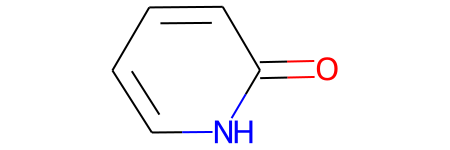

In [13]:
ori_mol

Then I parse the ori_mol, to get its atomic types, positions, and bonding relationships.

In [21]:
data = parse_rdmol(ori_mol)
atom_ele = data['element'].tolist()
atom_pos = data['pos'].tolist()
bond_index = data['bond_index'].tolist()
bond_type = data['bond_type'].tolist()

Basically, yuo may think this information is enough to recover a molecule, but it will cause some problem, let me show you.

In [22]:

n_atoms = len(atom_ele)

rd_mol = Chem.RWMol()
rd_conf = Chem.Conformer(n_atoms)

# add atoms and coordinates
for i, atom in enumerate(atom_ele):
    rd_atom = Chem.Atom(atom)
    rd_mol.AddAtom(rd_atom)
    rd_coords = Geometry.Point3D(*atom_pos[i])
    rd_conf.SetAtomPosition(i, rd_coords)
rd_mol.AddConformer(rd_conf)

# add bonds
for i, type_this in enumerate(bond_type):
    node_i, node_j = bond_index[0][i], bond_index[1][i]
    if node_i < node_j:
        if type_this == 1:
            rd_mol.AddBond(node_i, node_j, Chem.BondType.SINGLE)
        elif type_this == 2:
            rd_mol.AddBond(node_i, node_j, Chem.BondType.DOUBLE)
        elif type_this == 3:
            rd_mol.AddBond(node_i, node_j, Chem.BondType.TRIPLE)
        elif type_this == 4:
            rd_mol.AddBond(node_i, node_j, Chem.BondType.AROMATIC)
        else:
            raise Exception('unknown bond order {}'.format(type_this))

The rd_mol seems correct

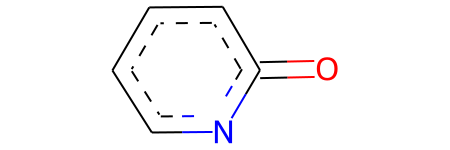

In [24]:
rd_mol

In [25]:
Chem.SanitizeMol(rd_mol)

[10:28:41] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6


KekulizeException: Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6

Now you can see the problem, I think the most annoying part in rdkit is "Can't kekulize mol.", even you are very sure that your molecules are chemically valid.

While reconstructing a molecule from atomic and bonding data, the molecule you tried to build ended up with some atoms connected only by aromatic bonds. This caused RDKit to raise a "Can't kekulize mol" error when it tried to depict the molecule's structure in a clearer bond format.

Ensure that atoms in aromatic rings, especially nitrogens, have the correct valence and connectivity. For instance, a nitrogen atom in a pyridine ring should have one implicit hydrogen if it's only connected to other atoms with aromatic bonds.

Thus, the solution is to provide implicit hydrogens directly.

In [42]:
data = parse_rdmol(ori_mol)
atom_ele = data['element'].tolist()
atom_pos = data['pos'].tolist()
bond_index = data['bond_index'].tolist()
bond_type = data['bond_type'].tolist()

n_atoms = len(atom_ele)

rd_mol = Chem.RWMol()
rd_conf = Chem.Conformer(n_atoms)

# add atoms and coordinates
for i, atom in enumerate(atom_ele):
    rd_atom = Chem.Atom(atom)
    # Check for aromatic nitrogen and add an explicit Hydrogen
    if atom == 7 and all(b == 4 for b in bond_type if (bond_index[0][i] == 6 or bond_index[1][i] == 6)):
        rd_atom.SetNumExplicitHs(1)
    rd_mol.AddAtom(rd_atom)
    rd_coords = Geometry.Point3D(*atom_pos[i])
    rd_conf.SetAtomPosition(i, rd_coords)

rd_mol.AddConformer(rd_conf)

# add bonds
for i, type_this in enumerate(bond_type):
    node_i, node_j = bond_index[0][i], bond_index[1][i]
    if node_i < node_j:
        if type_this == 1:
            rd_mol.AddBond(node_i, node_j, Chem.BondType.SINGLE)
        elif type_this == 2:
            rd_mol.AddBond(node_i, node_j, Chem.BondType.DOUBLE)
        elif type_this == 3:
            rd_mol.AddBond(node_i, node_j, Chem.BondType.TRIPLE)
        elif type_this == 4:
            rd_mol.AddBond(node_i, node_j, Chem.BondType.AROMATIC)
        else:
            raise Exception('unknown bond order {}'.format(type_this))
        

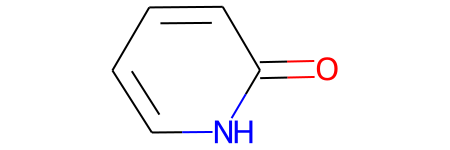

In [43]:
rd_mol

In [39]:
Chem.SanitizeMol(rd_mol)

rdkit.Chem.rdmolops.SanitizeFlags.SANITIZE_NONE

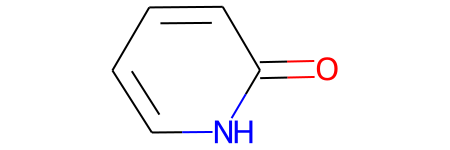

In [40]:
rd_mol

if atom == 7 and all(b == 4 for b in bond_type if (bond_index[0][i] == 6 or bond_index[1][i] == 6)):
if atom == 7: This part of the condition checks if the current atom is a nitrogen atom, as atomic number 7 corresponds to nitrogen.

all(b == 4 for b in bond_type if (bond_index[0][i] == 6 or bond_index[1][i] == 6)):

This complex condition iterates over all the bond types (b in bond_type) associated with the nitrogen atom (with index 6, as indexed from 0).
It checks if all these bonds are aromatic (b == 4).
If all bonds of this nitrogen atom are aromatic, the condition becomes true.
In simple terms, the combined condition checks if the current atom is a nitrogen atom and all of its bonds are aromatic. If these criteria are met, the nitrogen atom might have an implicit hydrogen, which can help resolve the kekulization problem. By ensuring that such nitrogens are given their due implicit hydrogen, we can prevent kekulization errors when depicting the molecule's structure.

Sulfur, with an atomic number of 16, does occasionally appear in aromatic systems (e.g., thiophene). Sulfur in aromatic rings usually doesn't have the same implicit hydrogen consideration as nitrogen does. However, the representation of sulfur in aromatic systems can still lead to issues, especially if other parts of the molecule interact with the sulfur atom or if there are charges to consider. Thus, the sulfur code is:

if atom == 16 and all(b == 4 for b in bond_type if (bond_index[0][i] == sulfur_index or bond_index[1][i] == sulfur_index)):


But I highly recommend the most safe way, instead of automatically detect the implicit H, we can directly assign them from the original molecules. 

In [44]:
data = parse_rdmol(ori_mol)
atom_ele = data['element'].tolist()
atom_pos = data['pos'].tolist()
bond_index = data['bond_index'].tolist()
bond_type = data['bond_type'].tolist()
implicit_hydrogen = data['implicit_hydrogen'].tolist() # record the implicit hydrogen information
n_atoms = len(atom_ele)

rd_mol = Chem.RWMol()
rd_conf = Chem.Conformer(n_atoms)

# add atoms and coordinates
for i, atom in enumerate(atom_ele):
    rd_atom = Chem.Atom(atom)

    rd_atom.SetNumExplicitHs(implicit_hydrogen[i]) # add explicit hydrogen

    rd_mol.AddAtom(rd_atom)
    rd_coords = Geometry.Point3D(*atom_pos[i])
    rd_conf.SetAtomPosition(i, rd_coords)

rd_mol.AddConformer(rd_conf)

# add bonds
for i, type_this in enumerate(bond_type):
    node_i, node_j = bond_index[0][i], bond_index[1][i]
    if node_i < node_j:
        if type_this == 1:
            rd_mol.AddBond(node_i, node_j, Chem.BondType.SINGLE)
        elif type_this == 2:
            rd_mol.AddBond(node_i, node_j, Chem.BondType.DOUBLE)
        elif type_this == 3:
            rd_mol.AddBond(node_i, node_j, Chem.BondType.TRIPLE)
        elif type_this == 4:
            rd_mol.AddBond(node_i, node_j, Chem.BondType.AROMATIC)
        else:
            raise Exception('unknown bond order {}'.format(type_this))
        

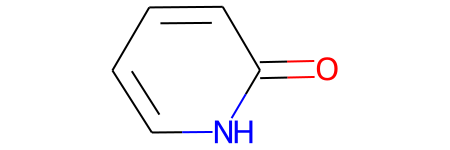

In [45]:
rd_mol

In [46]:
Chem.SanitizeMol(rd_mol)

rdkit.Chem.rdmolops.SanitizeFlags.SANITIZE_NONE